

# Importing Library 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input

In [ ]:
from keras.applications.vgg19 import VGG19,preprocess_input

In [ ]:
!unzip '/content/drive/MyDrive/data/archive.zip' -d '/content/drive/MyDrive/dataset'

Archive:  /content/drive/MyDrive/data/archive.zip
replace /content/drive/MyDrive/dataset/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# PREPROCESSING DATASET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                  #  zoom_range=0.2,
                                  #  horizontal_flip=True,
                                  #  vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)



Found 4098 images belonging to 4 classes.


In [ ]:
len(train_dataset)

33

In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


# DenseNet169

In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer='adam')

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 1.2190 - auc: 0.8208 
Epoch 1: val_auc improved from inf to 0.68633, saving model to ./best_weights.hdf5
33/33 [==============================] - 1217s 36s/step - loss: 1.2190 - auc: 0.8208 - val_loss: 4.4517 - val_auc: 0.6863
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 0.8314 - auc: 0.8952 
Epoch 2: val_auc did not improve from 0.68633
33/33 [==============================] - 1167s 35s/step - loss: 0.8314 - auc: 0.8952 - val_loss: 2.6584 - val_auc: 0.7193
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 0.6545 - auc: 0.9297 
Epoch 3: val_auc did not improve from 0.68633
33/33 [==============================] - 1149s 35s/step - loss: 0.6545 - auc: 0.9297 - val_loss: 2.4067 - val_auc: 0.7803
Epoch 4/5
33/33 [==============================] - ETA: 0s - loss: 0.5579 - auc: 0.9470 
Epoch 4: val_auc did not improve from 0.68633
33/33 [==============================] - 1193s 36s/step -

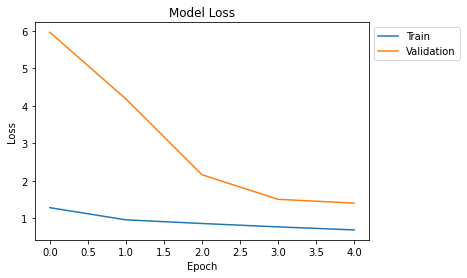

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

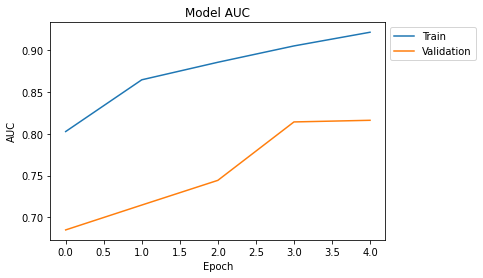

In [ ]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model.evaluate(test_dataset)

10/10 [==============================] - 318s 32s/step - loss: 1.1516 - auc: 0.8660


[1.1515650749206543, 0.8660053610801697]

# ResNet 50

In [ ]:
base_model_2 = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model_2.trainable = False
base_model_2.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(4,activation='softmax')
model2 = tf.keras.Sequential([
  base_model_2,
  global_average_layer,
  #keras.layers.flatten(),
  keras.layers.BatchNormalization(),  
  #keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)               1

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint("mri_resnet50.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
history1 = model2.fit(train_dataset,
                        validation_data=valid_dataset,epochs=20,callbacks=[checkpoint],batch_size=16)


Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.5437
Epoch 1: accuracy improved from -inf to 0.54368, saving model to mri_resnet50.h5
33/33 [==============================] - 57s 2s/step - loss: 0.9292 - accuracy: 0.5437 - val_loss: 1.0282 - val_accuracy: 0.4927
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.5488
Epoch 2: accuracy improved from 0.54368 to 0.54880, saving model to mri_resnet50.h5
33/33 [==============================] - 57s 2s/step - loss: 0.9250 - accuracy: 0.5488 - val_loss: 1.0831 - val_accuracy: 0.5005
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.5588
Epoch 3: accuracy improved from 0.54880 to 0.55881, saving model to mri_resnet50.h5
33/33 [==============================] - 58s 2s/step - loss: 0.9241 - accuracy: 0.5588 - val_loss: 1.0298 - val_accuracy: 0.4731
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.8786 - accur

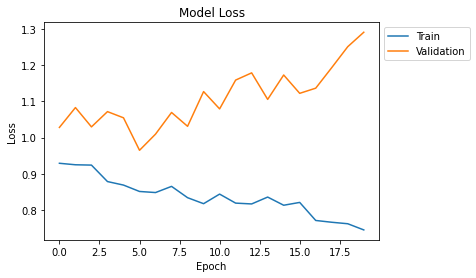

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

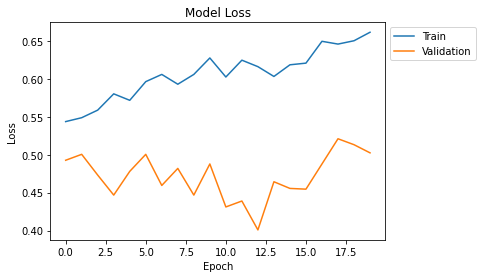

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model2.evaluate(test_dataset)

10/10 [==============================] - 873s 97s/step - loss: 0.9672 - accuracy: 0.5489


[0.9671676754951477, 0.548866331577301]

# VGG16

In [ ]:
base_model_3=VGG16(input_shape=(224,224,3),
                 include_top=False,
                 weights='imagenet')
base_model_3.trainable = False
base_model_3.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model3=Sequential()
model3.add(base_model_3)

model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(2048))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1024))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4,activation='softmax'))

In [ ]:
model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2048)              51382272  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 2048)             

In [ ]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history3=model3.fit(train_dataset,
                        validation_data=valid_dataset,steps_per_epoch=len(train_dataset)//16,
                        epochs = 5,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 2.0677 - accuracy: 0.3203 
Epoch 1: val_accuracy improved from -inf to 0.01760, saving model to ./best_weights.hdf5
2/2 [==============================] - 235s 189s/step - loss: 2.0677 - accuracy: 0.3203 - val_loss: 3.4472 - val_accuracy: 0.0176
Epoch 2/5
2/2 [==============================] - ETA: 0s - loss: 1.7039 - accuracy: 0.4570 
Epoch 2: val_accuracy did not improve from 0.01760
2/2 [==============================] - 52s 32s/step - loss: 1.7039 - accuracy: 0.4570 - val_loss: 3.4865 - val_accuracy: 0.0147
Epoch 3/5
2/2 [==============================] - ETA: 0s - loss: 1.3194 - accuracy: 0.5273 
Epoch 3: val_accuracy improved from 0.01760 to 0.14565, saving model to ./best_weights.hdf5
2/2 [==============================] - 48s 27s/step - loss: 1.3194 - accuracy: 0.5273 - val_loss: 2.1820 - val_accuracy: 0.1457
Epoch 4/5
2/2 [==============================] - ETA: 0s - loss: 1.6047 - accuracy: 0.4385    
Epoch 4: va

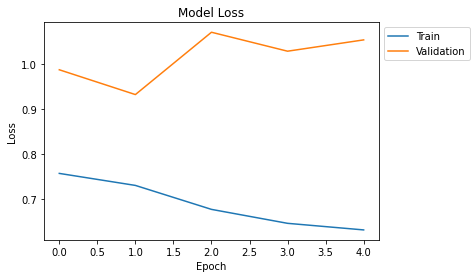

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

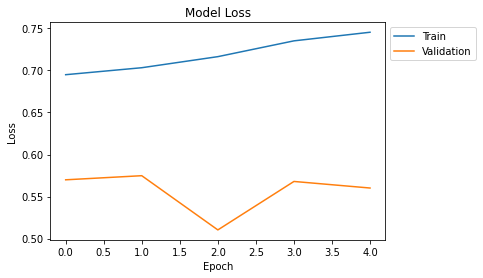

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model3.evaluate(test_dataset)


10/10 [==============================] - 7s 630ms/step - loss: 0.8586 - accuracy: 0.6560


[0.8585760593414307, 0.6559812426567078]

# Inception V3

In [ ]:
base_model_4 = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(224,224, 3), 
    weights='imagenet', 
    include_top=False,
    pooling='max'
)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
model = Sequential()

In [ ]:

base_output = base_model_4.output
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(base_output)
hl_reg = tf.keras.layers.Dropout(0.8)(hidden_layer)
output_layer = tf.keras.layers.Dense(4, activation='softmax')(hl_reg)

model4 = tf.keras.models.Model(inputs=base_model_4.input, outputs=output_layer)

In [ ]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history4=model4.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 2.2194 - accuracy: 0.4204
Epoch 1: val_accuracy did not improve from 0.57478
33/33 [==============================] - 82s 2s/step - loss: 2.2194 - accuracy: 0.4204 - val_loss: 53.1203 - val_accuracy: 0.3500
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.5100
Epoch 2: val_accuracy did not improve from 0.57478
33/33 [==============================] - 63s 2s/step - loss: 1.0168 - accuracy: 0.5100 - val_loss: 1.0979 - val_accuracy: 0.5005
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 0.9481 - accuracy: 0.5429
Epoch 3: val_accuracy did not improve from 0.57478
33/33 [==============================] - 63s 2s/step - loss: 0.9481 - accuracy: 0.5429 - val_loss: 1.7686 - val_accuracy: 0.5005
Epoch 4/5
33/33 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.5454
Epoch 4: val_accuracy did not improve from 0.57478
33/33 [=============================

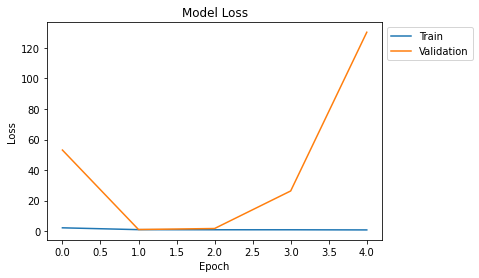

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

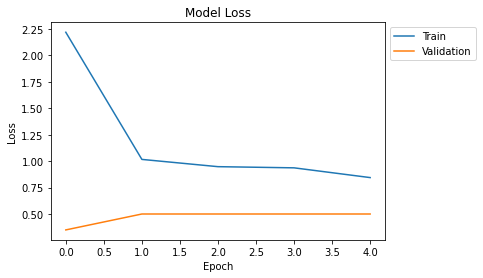

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model4.evaluate(test_dataset)

10/10 [==============================] - 3s 293ms/step - loss: 221.2993 - accuracy: 0.5004


[221.29928588867188, 0.5003909468650818]

# Autoencoder VAE

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
print(np.min(first_image), np.max(first_image)) 

0.0 0.9871975


In [ ]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [ ]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [ ]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
  
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
 

    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
  
    return model

In [ ]:
enc = encoder(input_encoder)

In [ ]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [ ]:
input_1 = (200,)
input_2 = (200,)

In [ ]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [ ]:
final = sampling(input_1,input_2)

In [ ]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [ ]:
dec = decoder(input_decoder)

In [ ]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss



In [ ]:
def vae_loss(y_true, y_pred, mean, log_var):
    #r_loss = mse_loss(y_true, y_pred)
    #kl_loss = kl_loss(mean, log_var)
    return  mse_loss(y_true, y_pred) + kl_loss(mean, log_var)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss 

In [ ]:
os.makedirs('/content/alzheimers_tf/training_weights', exist_ok=True)
os.makedirs('/content/alzheimers_tf/images', exist_ok=True)

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('/content/alzheimers_tf/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('/content/alzheimers_tf/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('/content/brain_tf/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 256, 256, 3)


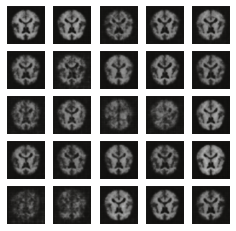

In [ ]:
train(normalized_ds, 130)

In [ ]:
enc.load_weights('/content/alzheimers_tf/training_weights/enc_99.h5')
dec.load_weights('/content/alzheimers_tf/training_weights/dec_99.h5')


In [ ]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > 5000:
        break

1/1 [==============================] - 0s 34ms/step


In [ ]:
embeddings.shape

(30, 200)

In [ ]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

1/1 [==============================] - 0s 149ms/step


In [ ]:
reconstruction.shape

(30, 256, 256, 3)

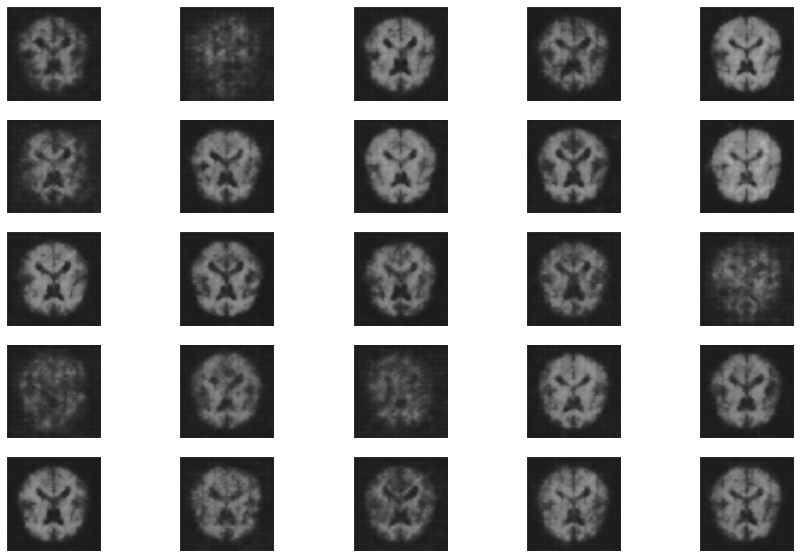

In [ ]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

1/1 [==============================] - 0s 153ms/step


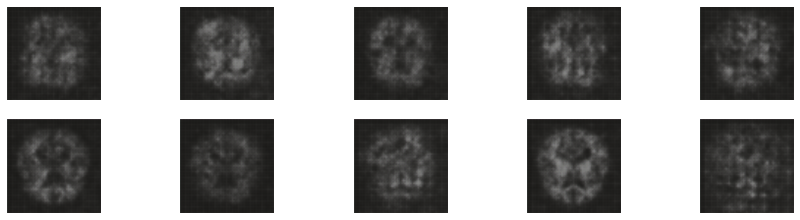

In [ ]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

# Prediction

In [ ]:
# FOR TEST_DATA THE ACCURACY
# DenseNet169-86%
# ResNet50-54%
# VGG16-66%
# InceptionV3-50%

98.86 % chances are there that the image is NonDemented


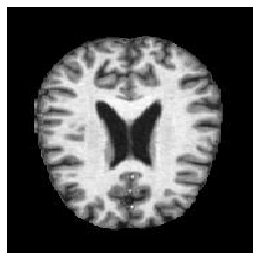

In [ ]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Alzemier-Datasety/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
# answer = model.predict_classes(img)
predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
probability = round(np.max(model.predict(img)*100),2)
print(probability, '% chances are there that the image is',idc[classes_x[0]])